In [1]:
# !pip -q install imblearn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import warnings
import statistics
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score
warnings.filterwarnings("ignore")

def plotFeatureImportances(features, importances, modelName):
    fig, ax = plt.subplots(1,1,figsize=(10,14))
    y_pos = np.arange(features.size)
    plt.clf()
    indexes = np.argsort(importances)
    plt.title("Feature importances - " + modelName)
    plt.barh(y_pos, np.sort(importances))
    plt.yticks(y_pos, features[indexes])
    plt.xlabel('F score')
    plt.ylabel("Feature")
    plt.show()

### 1) Load data: csv or Excel data

Data has been previously cleaned from unnecessary rows

In [3]:
data = pd.read_csv('lupus_data.tsv', sep = ";")

del data["runNo"] # Not meaningful
del data["CoreName"]

### 2) Inspect data
- (min, max, mean, standard deviation, range) of each feature
- number of each labels. Make a barplot.

In [4]:
data.describe()

,Sig070,Sp070,e_Sp070,Sp070/Sbg070,Sconv070,Stot070,e_Stot070,FWHMa070,FWHMb070,PA070,...,SigNH2,NH2p,NH2p/NH2bg,NH2conv,NH2bg,FWHMaNH2,FWHMbNH2,PANH2,NSED,CuTExflag
count,319.000000,319.000000,3.190000e+02,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,...,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000
mean,3.107837,-0.000339,9.822226e-03,0.000690,0.042218,0.116225,-0.376575,70.664577,48.827586,3.633229,...,20.925705,1.210157,0.497241,0.679310,2.523824,50.181818,29.777429,-2.163009,3.291536,0.404389
std,15.500711,0.026242,6.436894e-03,14.176305,0.339441,0.623970,9.675837,35.869483,34.918392,53.580425,...,31.249264,2.043134,0.417394,1.297559,1.682988,21.823150,14.138933,52.530660,0.677322,0.491544
min,0.000000,-0.074000,1.000000e-30,-203.230000,-0.870000,-5.400000,-170.000000,8.000000,8.000000,-90.000000,...,5.600000,0.170000,0.070000,0.100000,0.200000,18.000000,18.000000,-88.000000,2.000000,0.000000
25%,0.000000,-0.022000,5.000000e-03,0.020000,-0.175000,-0.034000,-0.007150,48.000000,22.000000,-42.000000,...,9.400000,0.460000,0.245000,0.200000,1.400000,35.000000,20.000000,-48.000000,3.000000,0.000000
50%,0.000000,0.002300,1.000000e-02,0.250000,0.020000,0.059000,0.013000,63.000000,41.000000,9.000000,...,13.600000,0.790000,0.380000,0.400000,2.100000,45.000000,26.000000,-5.000000,3.000000,0.000000
75%,3.250000,0.017000,1.000000e-02,0.820000,0.230000,0.265000,0.240000,84.000000,66.500000,48.000000,...,22.750000,1.315000,0.580000,0.700000,3.200000,61.000000,34.000000,43.000000,4.000000,1.000000
max,267.700000,0.081000,2.000000e-02,97.090000,1.100000,3.700000,12.000000,295.000000,208.000000,90.000000,...,470.500000,29.610000,3.110000,17.400000,14.400000,163.000000,131.000000,90.000000,5.000000,1.000000


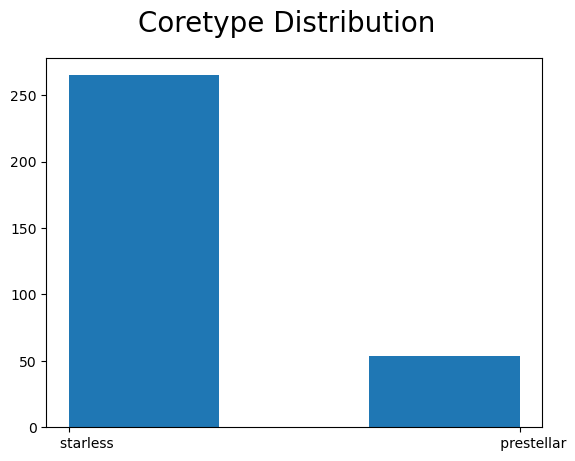

In [5]:
plt.hist(data["Coretype"], bins = 3)
plt.suptitle('Coretype Distribution', fontsize=20)
plt.show()

In [6]:
#replace starless with 1 and prestellar with 0

data["Coretype"] = data["Coretype"].str.lstrip().str.rstrip().replace("starless", 1).replace("prestellar", 0)

This Dataset is highly imbalanced and the ratio of Class-1 to Class-2 instances is 250:50, more concisely 5:1. This happens a lot in real Dataset coming from real case scenarios, for that reason we will have to handle this difference in the target variable.

If that difference is not mitigated our algorithm(s) would predict only the "starless" scenario and would be accurate the majority of the times. The approach I will follow in this notebook is called Resampling. It can be performed in the following ways:

- **Undersampling**: The process where you randomly delete some of the observations from the majority class in order to match the numbers with the minority class

- **Oversampling**: This process is a little more complicated than undersampling. It is the process of generating synthetic data that tries to randomly generate a sample of the attributes from observations in the minority class. 

### 3) Build the classification model
- Split the data into training and testing subset (70%/30%, 80%/20%)
- Choose at least 3 algorithms from sklearn ( https://scikit-learn.org/stable/supervised_learning.html#supervised-learning)
- Build the classification model with those algorithms only on the training subset
- Evaluate the model using the testing subset

##### Preliminary analysis

In [7]:
# Create correlation matrix
corr_matrix = data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

data.drop(to_drop, axis=1, inplace=True) #Dropped ['Sp350', 'Sconv350', 'FWHMa350', 'Sig500', 'Sp500', 'NH2p', 'NH2conv'] since they have an high correlation and won't impact our analysis.

In [8]:
X = data.drop('Coretype',axis=1)
y = data['Coretype']

cols = X.columns
numerical_columns = X._get_numeric_data().columns
categorical_columns = list(set(cols) - set(numerical_columns))


#Scale the numerical 
numerical_columns_df = X[numerical_columns].values 
min_max_scaler = preprocessing.MinMaxScaler()
numerical_columns_df_scaled = min_max_scaler.fit_transform(numerical_columns_df)
X = pd.DataFrame(numerical_columns_df_scaled, columns = numerical_columns)


#Encode categorical columns
le = preprocessing.LabelEncoder()
for column in categorical_columns:
    X[column] = le.fit_transform(data[column])


In [9]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

y_train.value_counts()

1    217
0     38
Name: Coretype, dtype: int64

In [10]:
#class balance. OVersampling using RandomOverSampler technique. Artifically increased prestellar class
oversample = RandomOverSampler(sampling_strategy=1)
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [11]:
y_train.value_counts()

1    217
0    217
Name: Coretype, dtype: int64

##### Model training and testing

To assess the quality of our prediction I am going to use the F1 Score, suitable for imbalanced data ([link](https://towardsdatascience.com/the-f1-score-bec2bbc38aa6))


<center><img src="https://miro.medium.com/max/640/1*5V5OEP51o26FzwuEgqHojw.png" alt="drawing" width="450"/></center>


The F1 Score combines Precision and Recall into a single metric. In many situations, like automated benchmarking, or grid search, it is much more convenient to have only one performance metric rather than multiple.

Precision and Recall are performance metrics that are more suitable when having imbalanced data because they allow taking into account the type of errors (false positives or false negatives) that your model makes.


In [12]:

param_grid_log_regr = [ {"C":np.logspace(-3,3,7), 'penalty': ["l2", "none"], 'solver': ["newton-cg", "lbfgs", "liblinear", "sag"]} ]
param_grid_random_forest= [{'bootstrap': [True, False], 'max_depth': [20, 100, None], 'n_estimators': [200, 1000]}]
param_grid_svm = [ {'C': [0.1, 10, 1000], 'gamma': [1, 0.1, 0.01, 0.001],'kernel': ["linear", "poly"]}]
param_grid_xgb = [ { 'min_child_weight': [1, 5, 10],'gamma': [0.5, 1, 2], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'max_depth': [3, 4, 5], 'booster': ["gbtree", "gblinear", "dart"]}]
param_grid_nn = [ {"learning_rate": ["constant", "invscaling", "adaptive"], "activation":["sigmoid", "logistic"],'solver': ["lbfgs", "sgd", "adam"]}]
param_grid_dt = [ {'max_depth': [1, 4, 8] , "max_features": ["auto", "sqrt", "log2"], "splitter" : ["best", "random"], 'criterion': ["gini", "entropy", "log_loss"]}]
param_grid_ada = [{"n_estimators" : [50, 100]}]

models = [
      ('LogReg', LogisticRegression(), param_grid_log_regr), 
      ('RF', RandomForestClassifier(), param_grid_random_forest),
      ('AdaBoost', AdaBoostClassifier(), param_grid_ada),
      ('SVM', SVC(probability = True), param_grid_svm),
      ("NN", MLPClassifier(), param_grid_nn),
      ("Decision Trees", DecisionTreeClassifier(), param_grid_dt),
      ('XGB', XGBClassifier(), param_grid_xgb)
    ]

AVG Values for LogReg Accuracy: 0.84 Precision Score 0.91 Recall 0.88 F1 Score 0.89    {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
AVG Values for RF Accuracy: 0.83 Precision Score 0.81 Recall 1.0 F1 Score 0.9    {'bootstrap': True, 'max_depth': 20, 'n_estimators': 200}
AVG Values for AdaBoost Accuracy: 0.84 Precision Score 0.88 Recall 0.92 F1 Score 0.9    {'n_estimators': 50}
AVG Values for SVM Accuracy: 0.83 Precision Score 0.92 Recall 0.85 F1 Score 0.88    {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
AVG Values for NN Accuracy: 0.67 Precision Score 0.78 Recall 0.77 F1 Score 0.78    {'activation': 'sigmoid', 'learning_rate': 'constant', 'solver': 'lbfgs'}
AVG Values for Decision Trees Accuracy: 0.79 Precision Score 0.83 Recall 0.9 F1 Score 0.86    {'criterion': 'gini', 'max_depth': 1, 'max_features': 'auto', 'splitter': 'best'}
AVG Values for XGB Accuracy: 0.81 Precision Score 0.84 Recall 0.92 F1 Score 0.88    {'booster': 'gbtree', 'colsample_bytree': 0.6, 'gamma': 0.5, 'max_de

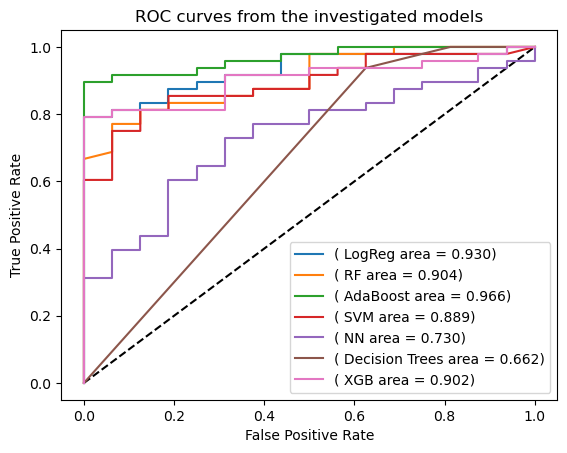

In [13]:
plt.plot([0, 1], [0, 1], 'k--')

for name, model, params in models:

    #Apply grid search with parameters specified in the dictionary to find the best combinations
    grid_search = GridSearchCV(model, params, cv=2, n_jobs=-1, scoring = "f1_micro")

    accuracies, f1scores, recalls, precisions = [], [], [], []
    
    for iteration_idx in range(3):
        # split X and y into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

        #class balance. OVersampling using SMOTE technique. I tried using Undersampling but results were worse
        oversample = RandomOverSampler(sampling_strategy=1)
        X_train, y_train = oversample.fit_resample(X_train, y_train)

        grid_search.fit(X_train, y_train)
        y_pred = grid_search.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
        f1scores.append(f1_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        
    print("AVG Values for", name, "Accuracy:", round(statistics.mean(accuracies) , 2), "Precision Score", round(statistics.mean(precisions) , 2), "Recall", round(statistics.mean(recalls) , 2), "F1 Score", round(statistics.mean(f1scores) , 2), "  ", grid_search.cv_results_["params"][0])


    # Plot ROC curves all in one graph to better understand the differences
    y_pred_prob_lr = grid_search.predict_proba(X_test)[:,1]
    fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_prob_lr)
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    precision_lr, recall_lr, th_lr = precision_recall_curve(y_test, y_pred_prob_lr,)
    plt.plot(fpr_lr, tpr_lr, label= "( " + name + ' area = %0.3f)' % roc_auc_lr)


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves from the investigated models')
plt.legend(loc='best')
plt.show()

A Receiver Operator Characteristic (ROC) curve is a graphical plot used to show the diagnostic ability of binary classifiers. A ROC curve is constructed by plotting the true positive rate (TPR) against the false positive rate (FPR). The true positive rate is the proportion of observations that were correctly predicted to be positive out of all positive observations (TP/(TP + FN)). Similarly, the false positive rate is the proportion of observations that are incorrectly predicted to be positive out of all negative observations (FP/(TN + FP)). Classifiers that give curves closer to the top-left corner indicate a better performance. As a baseline, a random classifier is expected to give points lying along the diagonal (FPR = TPR)

In our scenario, Since AdaBoost has the greatest Area under its curve we can state that it is the best performing modelon our data.

##### 4-5) Evaluate the model and Model Fine tuning


- Estimate the accuracy, precision, recall, f1-score
- Manually tune the model by changing the parameters of the algorithm to choose the best parameter settings
- Model with accuracy less than 80% is not accepted
- Model with accuracy larger than 95% is dubious, check (using different training/testing set)

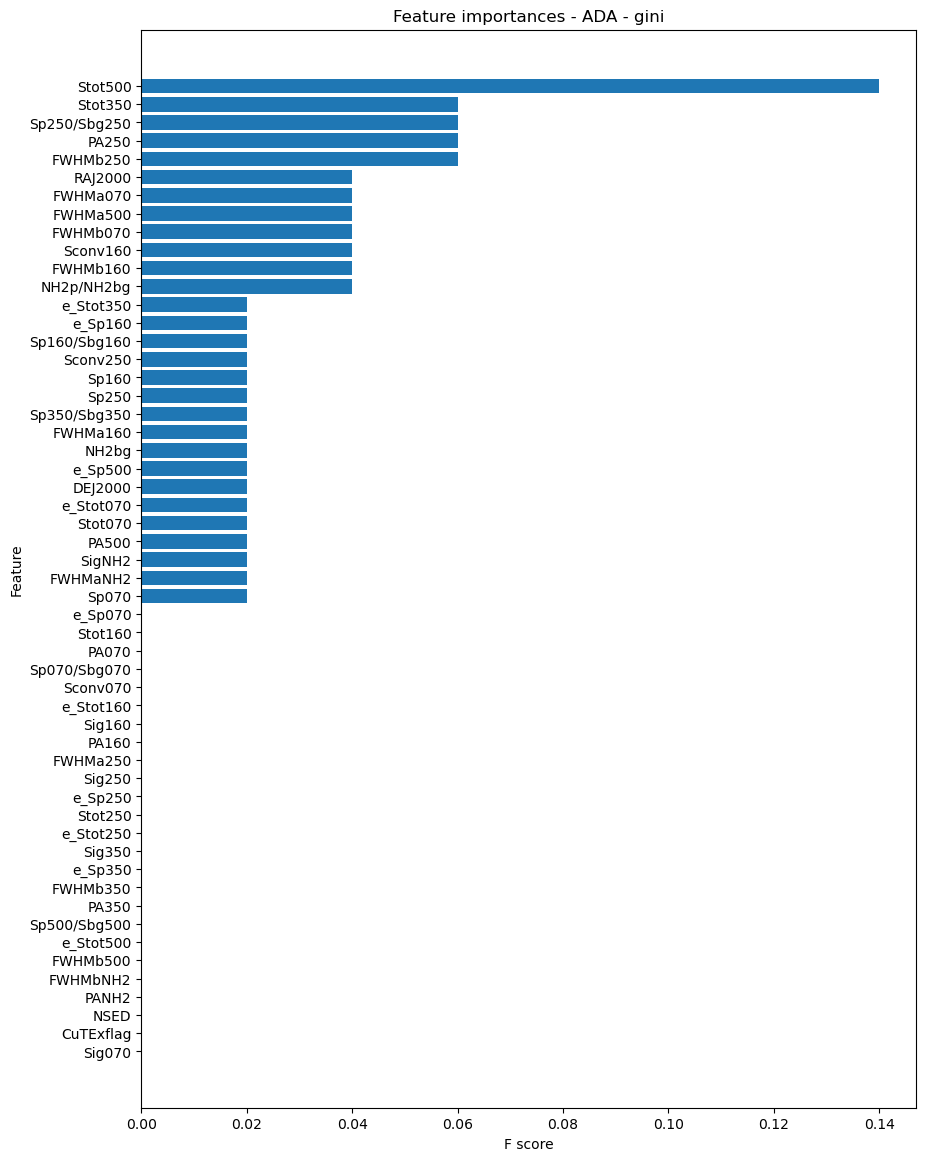

In [19]:
final_ada_model = AdaBoostClassifier(n_estimators =  50)
final_ada_model.fit(X_train, y_train)
plotFeatureImportances(X_test.columns, final_ada_model.feature_importances_, 'ADA - gini')

The most promising model seems to be ADABoost with a F1 Score of 0.9. Let's look at the confusion matrix:

<center><img src="https://miro.medium.com/max/1051/1*vbfuOkRGdcNkUXp8uEi4BA.png" alt="drawing" width="450"/>

In [29]:
cm = confusion_matrix(y_test, y_pred) 
print (cm)

[[ 9  7]
 [ 4 44]]


## 2nd step - Improvement of Final Score

The starting point for the improvement is the following result:

```
Model --> AdaBoostClassifier(n_estimators =  50)
Accuracy: 0.84 F1 Score: 0.9 Recall: 0.9 Precision 0.9
```

We should aim at slightly improving our score, reaching an 100% accuracy would be a non realistic scenario and cause issues. 

These are the options I have explored:
- Removing NaN vlaues (none found)
- Applying Transformations to columns (log transformation). Since we have negative values the simple standardization works better.
- Dropping less significant variables from the Feature Importances plot (worst results)
- Tried out different models combinations changing the classifiers and the architecture of the different models.


What, in the end, solved the task was lowering the number of estimators in our AdaBoost model. 

This is the final result:

```
Model --> AdaBoostClassifier(n_estimators =  20)
Accuracy: 0.89 F1 Score: 0.93 Recall: 0.96 Precision 0.9

```

In short, AdaBoost works in that way that it trains in subsequent iterations and then measures the error of all available weak classifiers. In each subsequent iteration, the "validity" of incorrectly qualified observations is increased, so that classifiers pay more attention to them. In case n_estimators=20 its look like we have the perfect fit so for bigger values of n_estimators model starts to overfit, which gives worse performance.

In [79]:
np.random.seed(123)

data = pd.read_csv('lupus_data.tsv', sep = ";")

del data["runNo"] # Not meaningful
del data["CoreName"]

# Create correlation matrix
corr_matrix = data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

data.drop(to_drop, axis=1, inplace=True) #Dropped ['Sp350', 'Sconv350', 'FWHMa350', 'Sig500', 'Sp500', 'NH2p', 'NH2conv'] since they have an high correlation and won't impact our analysis.

data["Coretype"] = data["Coretype"].str.lstrip().str.rstrip().replace("starless", 1).replace("prestellar", 0)

In [80]:
X = data.drop('Coretype',axis=1)
y = data['Coretype']

cols = X.columns
numerical_columns = X._get_numeric_data().columns
categorical_columns = list(set(cols) - set(numerical_columns))


#Scale the numerical 
numerical_columns_df = X[numerical_columns].values 
min_max_scaler = preprocessing.MinMaxScaler()
numerical_columns_df_scaled = min_max_scaler.fit_transform(numerical_columns_df)
X = pd.DataFrame(numerical_columns_df_scaled, columns = numerical_columns)



#Encode categorical columns
le = preprocessing.LabelEncoder()
for column in categorical_columns:
    X[column] = le.fit_transform(data[column])


In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

#class balance. Oversampling. I tried using Undersampling but results were worse
oversample = RandomOverSampler(sampling_strategy=1)
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [89]:
final_ada_model = AdaBoostClassifier(n_estimators =  20)
final_ada_model.fit(X_train, y_train)
y_pred = final_ada_model.predict(X_test)

print("Accuracy:", round(accuracy_score(y_test, y_pred), 2), "F1 Score:", round(f1_score(y_test, y_pred),2),"Recall:", round(recall_score(y_test, y_pred),2) , "Precision", round(precision_score(y_test, y_pred),2))

Accuracy: 0.89 F1 Score: 0.93 Recall: 0.96 Precision 0.9
